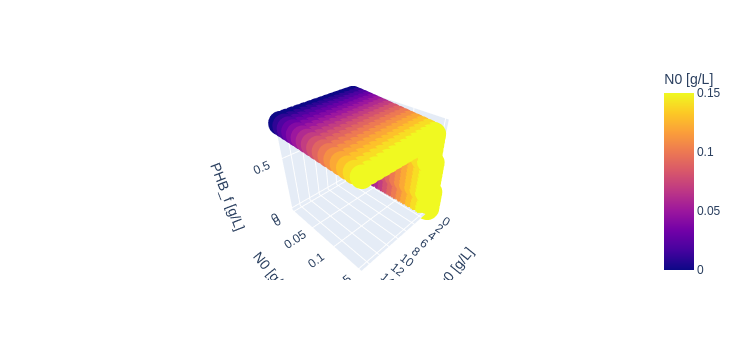

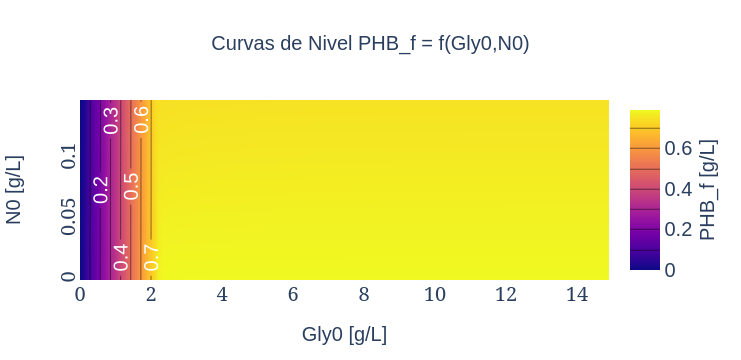

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 10 19:20:41 2023

############################################ 
#                                          #
# MODULO DE OPTIMIZACION TOSCA             #
# PARA VARIAR CONDICIONES INCIALES         #
# VISUALIZACION FUNCION OBJETIVO VS        #
# VARIABLES MANIPULADAS                    #
#                                          #
############################################ 

@author: Franco Neme
"""



#%% CARGA DE LIBRERIAS
# = = = = = = = = = = =

import numpy as np
from scipy.integrate import odeint
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go



#%% FUNCIONES (expresiones intermedias)
# = = = = = = = = = = = = = = = = = = =

def f_mu_x_R(mu_m, N, k_N, k_IN, Gly, k_IG, k_G):
    
    mu_x_R = ( (mu_m * N)/(k_N + N) ) * ( 1 / ( 1 + (N/k_IN) ) ) * ( Gly / (Gly *  (1 + (Gly/k_IG) ) + k_G) ) 
    
    return mu_x_R


def f_mu_p(beta, Gly, k_p, N, k_INP):#, n, PHB, k_d):
    
    mu_p = ( ( beta * Gly) / (Gly + k_p + ( (N)**2 / k_INP) ) ) # * ( 1 - ( (PHB**n) / (PHB**n + k_d)  ) )
    
    return mu_p



#%% SETEO DE LAS CONDICIONES EXPERIMENTALES
# = = = = = = = = = = = = = = = = = = = = =


# Tiempo de simulacion
# --------------------

t = np.arange(0,130,1)

# Cond. Inic.
# -----------

x_R0 = 0.25 # g/L
Gly0 = 25 # g/L 
PHB0 = 0 # g/L
N0 = 0.2 # g/L

Balances0 = [x_R0, Gly0, PHB0, N0]


# Cond. Contorno.
# ---------------



#%% PARAMETROS
# = = = = = = =

mu_m = 0.35 # h**−1
k_N = 0.01 # g/L
k_IN = 0.27 # g/L
k_IG = 86.31 # g/L
k_G = 1.05 # g/L
k_x = 9.00 # g/L
n = 1.00 # 
beta = 0.14 # h**−1
k_p = 0.01 # g/L
k_INP = 1E-3 # (g/L)**2
Y_xRGly = 0.35 # g/g
Y_PHBGly = 0.29 # g/g
Y_xRN = 6.0 # g/g
k_d = 9.00 # g/L

parms = mu_m, k_N, k_IN, k_IG, k_G, beta, k_p, k_INP, k_x, Y_xRGly, Y_PHBGly, Y_xRN



#%% RESOLUCION DE SIST. DE ECUACIONES DIF.
# = = = = = = = = = = = = = = = = = = = = =

def f(Balances, mu_m, k_N, k_IN, k_IG, k_G, k_x, beta, k_p, k_INP, Y_xRGly, Y_PHBGly, Y_xRN, t):
    
    # Tupla de salida 
    # ---------------
    
    x_R, Gly, PHB, N  = Balances
    
    # Asignacion de variables acorde a sus funciones 
    # ----------------------------------------------
    
    mu_x_R = f_mu_x_R(mu_m, N, k_N, k_IN, Gly, k_IG, k_G)
    mu_p = f_mu_p(beta, Gly, k_p, N, k_INP)
    
    # Sistema ODE
    # -----------
    
    dx_R_dt = mu_x_R * x_R * (1 - ((x_R + PHB)/k_x)  )
    dGly_dt = - ( (1/Y_xRGly) * mu_x_R + (1/Y_PHBGly) * mu_p ) * x_R * (1 - ((x_R + PHB)/k_x)  )
    dPHB_dt = mu_p * x_R * (1 - ((x_R + PHB)/k_x)  )
    dN_dt = - (1/Y_xRN) * mu_x_R * x_R * (1 - ((x_R + PHB)/k_x)  )
    
    # Salida de la func.
    # ------------------
    
    salida_func =  np.array([dx_R_dt, dGly_dt, dPHB_dt , dN_dt])
    
    return salida_func



#%% ODEINT (BARRIDO DE CONDICIONES INICIALES)
# = = = = = = = = = = = = = = = = = = = = = =

# Gly0 = np.arange(23,28,1)
# N0 = np.arange(0.18,0.22,0.01)

Gly0 = np.arange(0,16,0.1)
N0 = np.arange(0,0.16,0.001)

Gly0_ls = []
N0_ls = []
PHB_f = []

for i in Gly0:
    
    Balances0[1] = i
    
    for j in N0:
        
        Balances0[3] = j
        
        resultados = odeint(f, Balances0, t, args=parms, mxstep = 5000)

        Gly0_ls.append(round(i,0))
        N0_ls.append(round(j,2))
        PHB_f.append(round(resultados[:,2][-1],4))
    

df_opt = pd.DataFrame({'Gly0 [g/L]': Gly0_ls, 'N0 [g/L]': N0_ls, 'PHB_f [g/L]': PHB_f})

valores_opt = df_opt.loc[df_opt['PHB_f [g/L]'].idxmax()]


#%% GRAFICO 3D
# = = = = = = =

fig = px.scatter_3d(df_opt, x='Gly0 [g/L]', y='N0 [g/L]', z='PHB_f [g/L]',
              color='N0 [g/L]')
fig.show()

# fig.write_html("/home/franco/Escritorio/UNRN/Cuarto año/Segundo Cuatri/Bioprocesos II/FINAL/Presentaciones/Seminario/Simulaciones/min_dos_opt_tresD.html")
# fig.write_html("/home/fneme/Descargas/M05_R2016-main/Simulaciones/Salidas/Graficas_Opt_CI/min_dos_opt_tresD.html")

#%% CONTOUR PLOT
# = = = = = = = =

# Armado de [] para plot de Z 
# ---------------------------

n_eval = len(Gly0)

z_N = []
z_k = []

j = 0

for k in range(n_eval):

    for i in range(n_eval):
        
        # print('i:' + str(i), 'j:' + str(j), 'N0:' + str(df_opt['N0'][j]))
        
        z_k.extend([df_opt['PHB_f [g/L]'][j]])
        
        j = n_eval*(i+1) + k
    
    z_N.append(z_k)
    
    j = k + 1
    z_k = []

    
# Curvas de nivel
# ---------------

fig_d = go.Figure(data =
    go.Contour(
        z= z_N,
        x= Gly0, # horizontal axis
        y= N0, # vertical axis
        
        contours=dict(
            coloring ='heatmap',
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 20,
                color = 'white',
            )
        ),
         colorbar=dict(
            title='PHB_f [g/L]', # title here
            titleside='right',
            titlefont=dict(
                size=20,
                family='Arial, sans-serif'),
            tickfont=dict(size=20)
        )))


fig_d.update_layout(title_text='Curvas de Nivel PHB_f = f(Gly0,N0)', title_x=0.5, title_font = {"size": 20})

fig_d.update_xaxes(
        tickangle = 0,
        title_text = "Gly0 [g/L]",
        title_font = {"size": 20},
        title_standoff = 20,
        tickfont=dict(family='Rockwell', size=20)) 


fig_d.update_yaxes(
        tickangle = 90*3,
        title_text = "N0 [g/L]",
        title_font = {"size": 20},
        title_standoff = 20,
        tickfont=dict(family='Rockwell', size=20)) 

fig_d.show()

# fig_d.write_html("/home/franco/Escritorio/UNRN/Cuarto año/Segundo Cuatri/Bioprocesos II/FINAL/Presentaciones/Seminario/Simulaciones/min_opt_CurvasDeNivel.html")
fig_d.write_html("/home/franco/Escritorio/UNRN/Cuarto año/Segundo Cuatri/Bioprocesos II/FINAL/Presentaciones/Seminario/Simulaciones/Salidas/Graficas_Opt_CI/min_opt_CurvasDeNivel.html")